# Exercises Day05

In [1]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import scipy 
import matplotlib.pyplot as plt
#from helper_functions import *

def normpdf(x : float, mu : float, sigma : float) -> float:
    """
        Normal distribution probability density function.
        
        :param x: x value
        :param mu: mean
        :param sigma: standard deviation
        
        :return: probability density function value
    """
    return 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-1.0 / 2 * ((mu - x) / sigma)**2)



## Ex01
For the discrete case we choose a proposal distribution that is simply bernoulli ditribution that is either $\Delta X[-1,1]$. The normalization constant $c$ is found by solving the equation

$$
\sum_{i=0}^m c\frac{A^i}{i!} = 1 \Leftrightarrow c = \frac{1575}{3830591}
$$

The function for running the MCMC for this problem is found in the python file helperfunctions.

In [2]:
m = 10
MCMC_iter = 10**5
service_mean = 8
arrival_mean = 1

random_ass_number = 1575 / 3830591  # <-- Alex found this with Maple-Magic
A = service_mean * arrival_mean

g = lambda x: (A**x) / (np.math.factorial(x) )
f = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_1(num_samples : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    num_iter = int(num_samples * (1 + burn_in_ratio))
    if X_0 is None:
        X_0 = np.random.randint(0, m + 1) # Random number between 0 and m (inclusive)

    samples = []
    samples.append(X_0)

    for _ in range(num_iter):
        delta_X = np.random.binomial(n=1, p=0.5)*2 - 1 # Number either -1 or 1
        X_curr = samples[-1]
        
        X_proposal = X_curr + delta_X  # <-- okay.. this is technically unecessary, but it's good practice to initialize variables (that would otherwise go out of scope)
        
    
        if X_proposal < 0:
            # Edge-case lower end
            X_proposal = m
        elif X_proposal > m:
            # Edge-case upper end
            X_proposal = 0 
            

        A = min(1.0, g(X_proposal) / g(X_curr))
        

        accept = np.random.binomial(n=1, p=A)
      
        if accept:
            samples.append(X_proposal)
        elif not accept:
            samples.append(X_curr)

    
    return samples[num_samples:]
        

Count of sampled points: [   2   20  109  296  656 1144 1538 1794 1761 1507 1174]


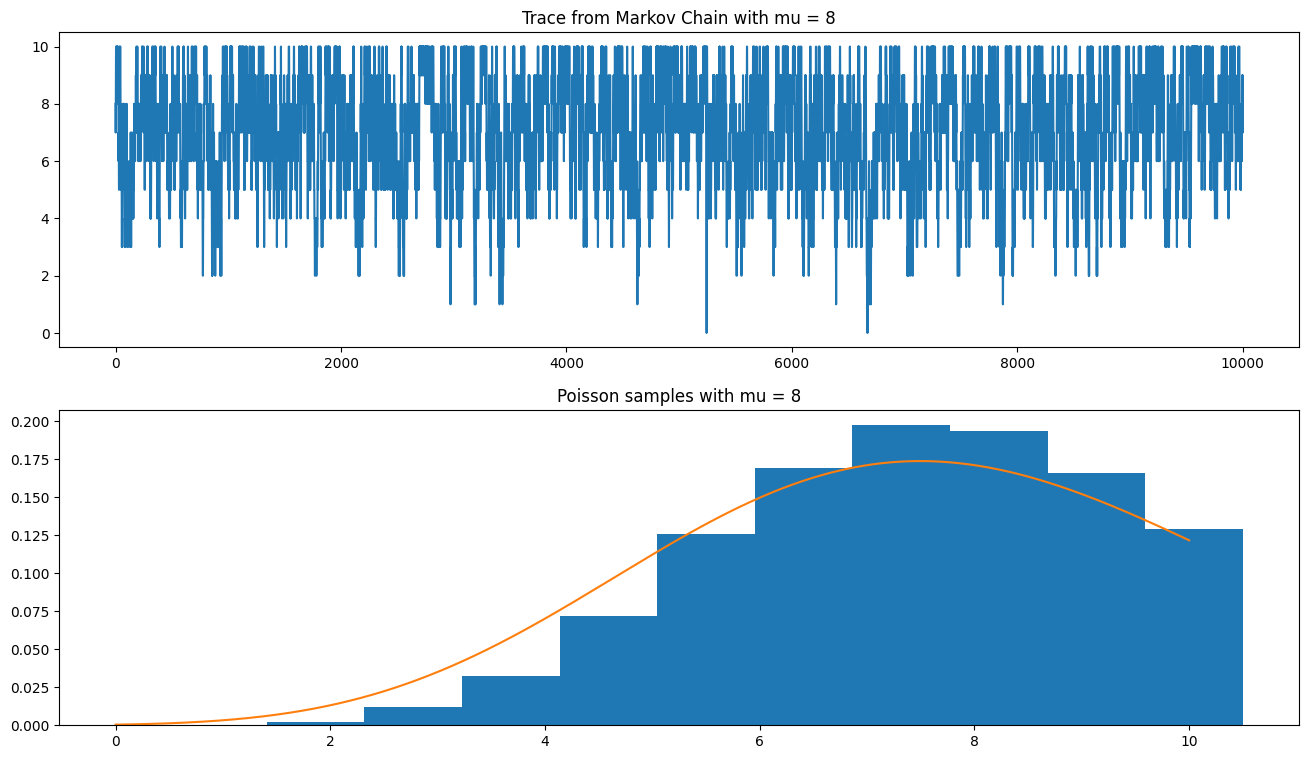

In [3]:
pois_samples = MCMC_1(MCMC_iter, burn_in_ratio=0.1)

# print(f"Poisson samples: \n{pois_samples}")
print(f"Count of sampled points: {np.histogram(pois_samples, bins = m + 1)[0]}")

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples)
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.title(f"Poisson samples with mu = {A}")
plt.hist(np.array(pois_samples) + 1/2, bins=m+1, density = True)
plt.plot(XX, Y)

plt.show()

From the trace of the parameter in the first plot we can se that the samples has converged, so the true distributions. From the second plot we can se that se true distribution follows the samples. 

$Chi^2$-test

In [4]:
def chi_squared_test_pois(pois : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For poisson distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
                        y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        :return p: returns the p-value of the test.
    """
    
    expected_num_in_bins = f(np.arange(0, num_bins + 1))
    
    # Divied into bins
    counts, _ = np.histogram(pois, bins=num_bins+1)
    counts = counts / len(pois)

    T = np.abs(np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins))
    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

chi_test = chi_squared_test_pois(pois_samples, m)
print(chi_test)

0.9999999999997833


Good $\chi^2$ results gives the same results.  

## Ex02
The normalization constant for the two dimensional case becomes
$$
\sum_{i=0}^m\sum_{j=10-i}^m c\frac{A_1^i}{i!}\frac{A_2^j}{j!} = 1 \Leftrightarrow c = \frac{1575}{3830591}
$$
It makes sense that the normalization constant is the same as for the previous as it is the same distribution but where $x=i+j$. 



### a) simply Metropolis-Hastings
we handle both dimensions at a time

In [21]:
m = 10
MCMC_iter = 10**5

random_ass_number =  1575 / 3830591
A1 = 4
A2 = 4

g2 = lambda x: A1**x[0] / np.math.factorial(x[0])  * A2**x[1] / np.math.factorial(x[1])
f2 = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_two_dim_boxed(num_samples : int, X_0: int = None, burn_in_ratio : float = 0.5, seed : int = 42):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        This is for the two-dimensional case.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    # initialization
    np.random.seed(seed=seed)
    num_iter = int(num_samples * (1 + burn_in_ratio))
    
    # Finidng our first guess (if none specified)
    if X_0 is None:
        first_sample = np.random.randint(0, m + 1)
        X_0 = np.array([first_sample, np.random.randint(0, 10 - first_sample + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and 10 - previously sampled number (inclusive)]
  
    samples = [X_0]

    for _ in range(num_iter):
        X_curr = samples[-1]
        
        # random guess
        delta_X = np.random.randint(-1, 2, size=2)
        
        # We can only move so discard a random walk if we are not moving
        while delta_X[0] == 0 and delta_X[1] == 0:
            delta_X = np.random.randint(-1, 2, size=2)
            
        X_proposal =  X_curr + delta_X
        
        # if out of bounds we just stay at the same point
        if X_proposal.sum() > m or X_proposal[0] < 0 or X_proposal[1] < 0:
            samples.append(X_curr)
            
        else:
            A = min(1, g2(X_proposal) / g2(X_curr))
            accept = np.random.binomial(n=1, p=A)
    
            if accept:
                samples.append(X_proposal)
            elif not accept:
                samples.append(X_curr)

    
    return samples[num_samples:]

Shape of samples: (10001, 2)
Unique values: [ 0  1  2  3  4  5  6  7  8  9 10]
Counts of samples: 
[   1   36  111  326  676 1088 1447 1776 1708 1564 1268]


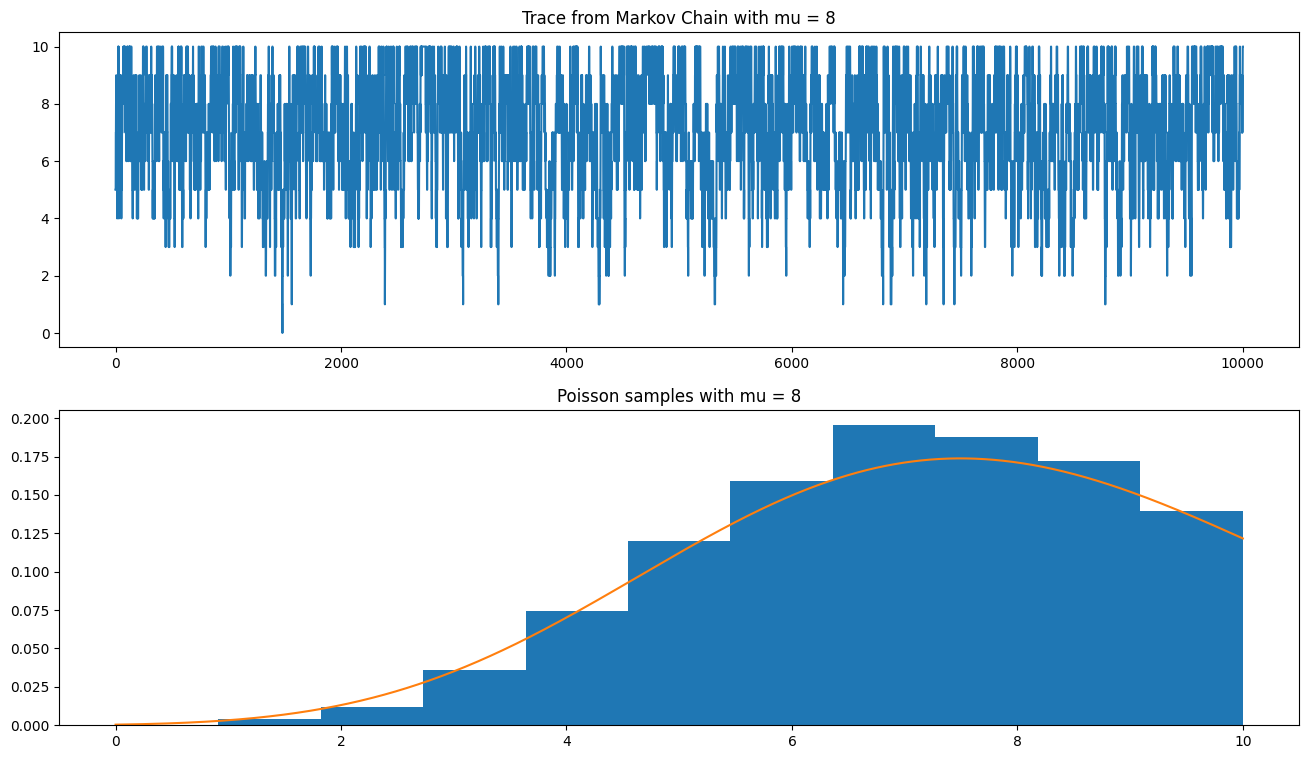

In [28]:
pois_samples = np.array(MCMC_two_dim_boxed(MCMC_iter, burn_in_ratio = 0.1))


# Debugging
sum_pois_samples = pois_samples.sum(axis = 1)
unique_pois_samples = np.unique(sum_pois_samples)
num_bins = len(unique_pois_samples)
#set_pois_samples = set(sum_pois_samples)
counts, _ = np.histogram(sum_pois_samples, bins = num_bins)
print(f"Shape of samples: {pois_samples.shape}")    # <-- shape is gonna be one more than iterations because we already append out intial guess
print(f"Unique values: {unique_pois_samples}")
#print(f"Set of samples: {set_pois_samples}")
print(f"Counts of samples: \n{counts}")


# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(sum_pois_samples)
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
plt.hist(sum_pois_samples, bins = num_bins, density = True)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.plot(XX, Y)
plt.title(f"Poisson samples with mu = {A}")

plt.show()

$Chi^2$ test

In [29]:
def chi_squared_test_pois(pois : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For poisson distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
                        y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        :return p: returns the p-value of the test.
    """
    
    expected_num_in_bins = f(np.arange(0, num_bins + 1))
    
    
    # Divied into bins
    counts, _ = np.histogram(pois, bins=num_bins+1)
    counts = counts / len(pois)

    T = np.abs(np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins))
    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

chi_test = chi_squared_test_pois(sum_pois_samples, num_bins)
print(chi_test)

0.9999998070422085


#### MCMC (not boxed)

In [48]:
def MCMC_two_dim(num_samples : int, m : int = 10, X_0: int = None, burn_in_ratio : float = 0.5, seed : int = 42):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        This is for the two-dimensional case.
        NOTE: The burn_in_ratio is added to the amount samples. I.e. the number of iterations
        are num_samples * (1 + burn_in_ratio).
        
        :param num_samples: Number of samples points from the MCMC
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    # initialization
    np.random.seed(seed=seed)
    num_iter = int(num_samples * (1 + burn_in_ratio))
    
    # Finidng our first guess (if none specified)
    if X_0 is None:
        first_sample = np.random.randint(0, m + 1)
        X_0 = np.array([first_sample, np.random.randint(0, m - first_sample + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and m - previously sampled number (inclusive)]
  
    samples = [X_0]

    for _ in range(num_iter):
        X_curr = samples[-1]
        
        # random guess
        delta_X = np.random.randint(-1, 2, size=2)
        
        # We can only move so discard a random walk if we are not moving
        while delta_X[0] == 0 and delta_X[1] == 0:
            delta_X = np.random.randint(-1, 2, size=2)
            
        X_proposal =  X_curr + delta_X
        
        if (X_curr.sum() == m or X_curr.sum() == m - 1) and delta_X.sum() == 2:
            # If we try to move beyond i + j = m, we stay at the same point
            biggest_indx = np.argmax(X_proposal)
            X_proposal[biggest_indx] = 0
            X_proposal[1 - biggest_indx] = (X_curr[biggest_indx] - X_curr[1 - biggest_indx]) % m+1 # <-- a*x + b = y 
            print(X_proposal, "diagonal edge case")
            
        elif X_curr[0] == 0 and X_curr[1] == 0 and (delta_X[0] == -1 or delta_X[1] == -1):
            # We are at (0, 0)
            if delta_X[0] == -1 and delta_X[1] == -1:
                print("a")
                X_proposal = np.array([m // 2, m // 2])
            elif delta_X[0] == -1 and delta_X[1] != -1:
                if delta_X[1] == 0:
                    print("b")
                    X_proposal = np.array([m, 0])
                elif delta_X[1] == 1:
                    print("c")
                    X_proposal = np.array([m - 1, 1])
            elif delta_X[1] == -1 and delta_X[0] != -1:
                if delta_X[0] == 0:
                    print("d")
                    X_proposal = np.array([0, m])
                elif delta_X[0] == 1:
                    print("e")
                    X_proposal = np.array([1, m - 1])
            print(X_proposal, "(0, 0) edge case")
            
        elif X_curr[0] == 0 and delta_X[0] == -1:
            # Edge-case lower end
            X_proposal = X_curr.copy()
            X_proposal[[0, 1]] = X_proposal[[1, 0]] # <-- swap
            print(X_proposal, "X edge case")   
             
        elif X_curr[1] == 0 and delta_X[1] == -1:
            # Edge-case lower end
            X_proposal = X_curr.copy()
            X_proposal[[0, 1]] = X_proposal[[1, 0]] # <-- swap
            print(X_proposal, "Y edge case")
            
        
        A = min(1, g2(X_proposal) / g2(X_curr))
        accept = np.random.binomial(n=1 , p=A)
 
        if accept:
            samples.append(X_proposal)
        elif not accept:
            samples.append(X_curr)

    
    return samples[num_samples:]

[6 0] diagonal edge case
[4 0] diagonal edge case
[0 2] diagonal edge case
[0 4] diagonal edge case
[2 0] diagonal edge case
[5 0] X edge case
[0 2] Y edge case
[2 0] X edge case
[0 2] Y edge case
[2 0] X edge case
[0 2] Y edge case
[2 0] X edge case
[2 0] X edge case
[1 0] X edge case
[0 1] Y edge case
[0 3] Y edge case
[0 2] diagonal edge case
[2 0] diagonal edge case
[7 0] diagonal edge case
[0 4] diagonal edge case
[2 0] diagonal edge case
[3 0] diagonal edge case
[5 0] X edge case
[0 5] Y edge case
[0 5] diagonal edge case
[5 0] X edge case
[3 0] X edge case
[0 3] Y edge case
[0 3] Y edge case
[3 0] X edge case
[0 4] Y edge case
[4 0] X edge case
[2 0] diagonal edge case
[0 2] diagonal edge case
[0 4] diagonal edge case
[0 6] Y edge case
[7 0] X edge case
[0 7] Y edge case
[7 0] X edge case
[0 6] Y edge case
[0 2] diagonal edge case
[0 2] diagonal edge case
[0 3] Y edge case
[4 0] diagonal edge case
[0 4] Y edge case
[4 0] X edge case
[0 8] Y edge case
[4 0] X edge case
[0 4] Y ed

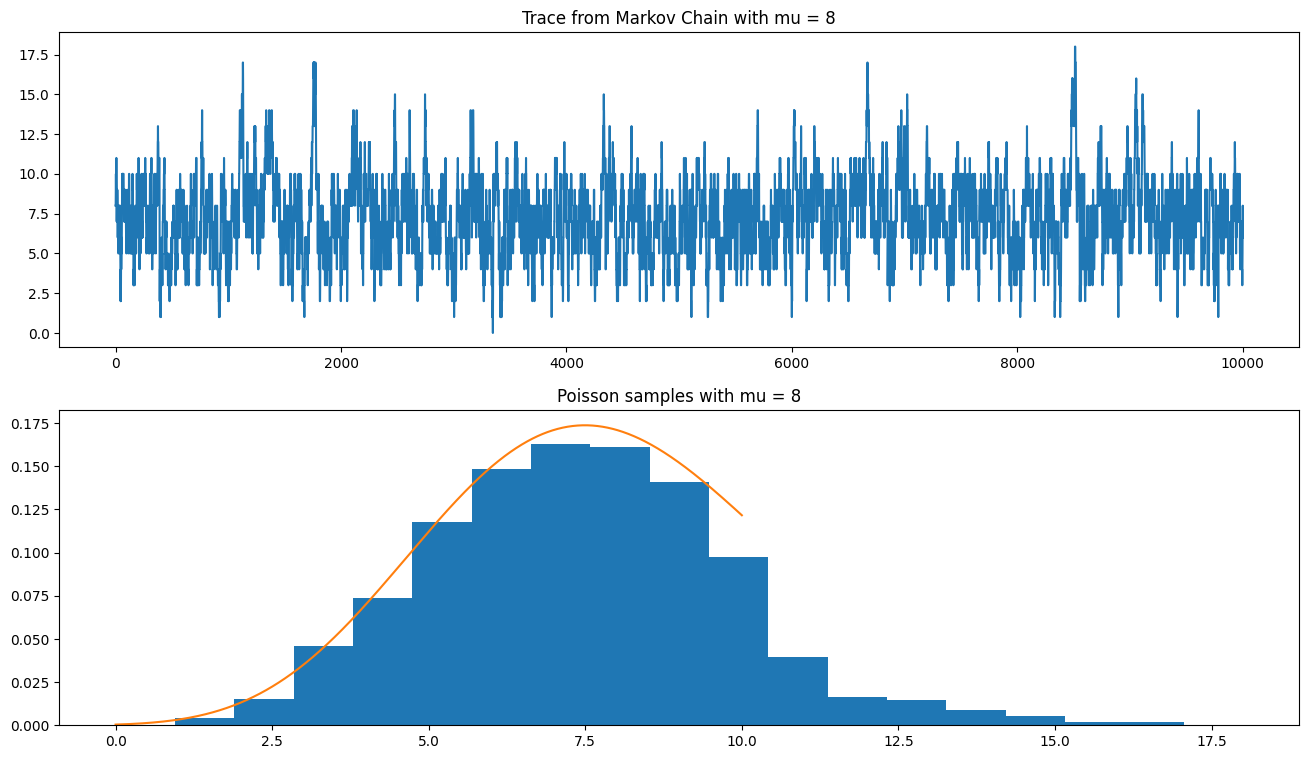

In [49]:
pois_samples = np.array(MCMC_two_dim(MCMC_iter, burn_in_ratio = 0.1))


# Debugging
sum_pois_samples = pois_samples.sum(axis = 1)
unique_pois_samples = np.unique(sum_pois_samples)
num_bins = len(unique_pois_samples)
#set_pois_samples = set(sum_pois_samples)
counts, _ = np.histogram(sum_pois_samples, bins = num_bins)
print(f"Shape of samples: {pois_samples.shape}")    # <-- shape is gonna be one more than iterations because we already append out intial guess
print(f"Unique values: {unique_pois_samples}")
#print(f"Set of samples: {set_pois_samples}")
print(f"Counts of samples: \n{counts}")


# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(sum_pois_samples)
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
plt.hist(sum_pois_samples, bins = num_bins, density = True)
XX = np.linspace(0, m, 1000)
Y = f(XX)
plt.plot(XX, Y)
plt.title(f"Poisson samples with mu = {A}")

plt.show()

### b) Metropolis-Hastings, coordinate wise
We accept/reject one dimension at a time


[0 3] diagonal edge case
[5 0] diagonal edge case
[5 0] diagonal edge case
[0 1] diagonal edge case
[0 1] diagonal edge case
[0 1] diagonal edge case
[3 0] diagonal edge case
[7 0] diagonal edge case
[7 0] diagonal edge case
[8 3] Y edge case
[0 8] diagonal edge case
[0 8] diagonal edge case
[0 8] diagonal edge case
[0 8] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 8] diagonal edge case
[0 8] diagonal edge case
[0 4] diagonal edge case
[6 3] Y edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[5 0] diagonal edge case
[5 0] diagonal edge case
[3 0] diagonal edge case
[0 1] diagonal edge case
[0 3] diagonal edge case
[0 5] diagonal edge case
[0 7] diagonal edge case
[3 8] X edge case
[2 0] diagonal edge case
[0 2] diagonal edge case
[4 0] diagonal edge case
[0 4] diagonal edge case
[0 4] diagonal edge case
[0 3] diagonal edge case
[0 3] diagonal edge case
[0 3] diagonal edge case
[3 0] diagonal edge case
[0 1] diagonal edge case
[4 5] X edge case
[4 

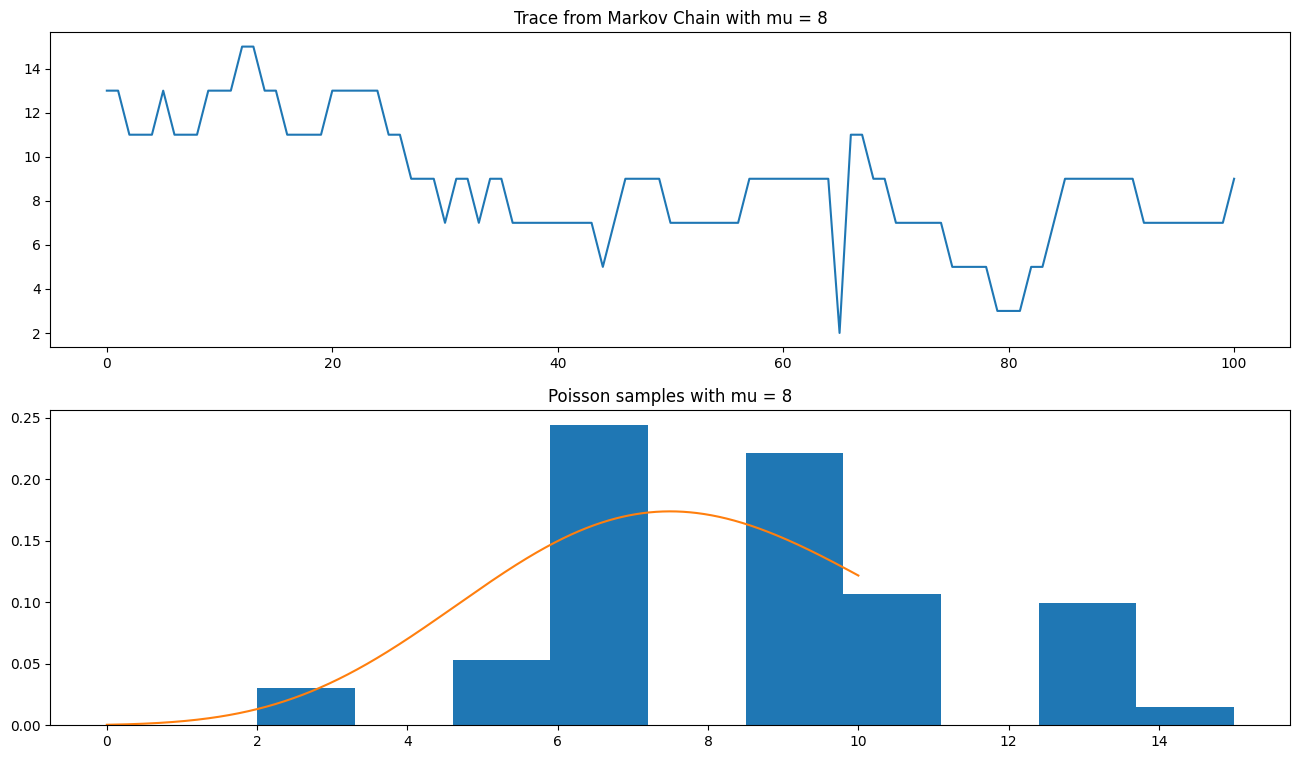

In [8]:
m = 10
MCMC_iter = 10**3

random_ass_number =  1575 / 3830591
A1 = 4
A2 = 4

g2 = lambda x: A1**x[0] / np.math.factorial(x[0])  * A2**x[1] / np.math.factorial(x[1])
f2 = lambda x: (random_ass_number * A**x)/ scipy.special.factorial(x)#(np.exp(-A) * A**x)/ scipy.special.factorial(x) 

def MCMC_two_coordinate(num_iter : int, X_0: int = None, burn_in_ratio : float = 0.5):
    """
        Markov Chain Monte Carlo scheme. We use the Metropolis-Hastings algorithm.
        
        :param num_iter: Number of iterations
        :param X_0: Initial value of the Markov Chain. If None, a random value between 0 and m is chosen.
        :param burn_in_ratio: The amount of burn-in we wish to apply (as a ratio)
        
        :return: Samples from the Markov Chain
    """
    
    sample_num = int(num_iter * (1 + burn_in_ratio))
    if X_0 is None:
        temp = np.random.randint(0, m + 1)
        X_0 = np.array([temp,np.random.randint(0, 10 - temp + 1)]) # [Random number between 0 and m (inclusive), Random number between 0 and 10 - previously sampled number (inclusive)]
  
    samples = []
    samples.append(X_0)

    for _ in range(sample_num):
        X_curr = samples[-1]
        
        for i in range(2):
            delta_X = np.random.binomial(n=1, p=0.5, size=2)*2 - 1 # Number either -1 or 1
            
            
            X_proposal = X_curr + delta_X 
            if X_curr[0] == 0 and delta_X[0] == -1:
                # Edge-case lower end
                X_proposal[0] = 0
                
            if X_curr[1] == 0 and delta_X[1] == -1:
                # Edge-case lower end
                X_proposal[1] = 0

            elif (X_curr.sum() == m or X_curr.sum() == m - 1) and delta_X.sum() == 2:
                # If we try to move beyond i + j = m, we stay at the same point
                X_proposal =  X_curr
        
            
            A = min(1, g(X_proposal) / g(X_curr))
            accept = np.random.binomial(n=1,p=A)
    
            if accept:
                samples.append(X_proposal)
            elif not accept:
                samples.append(X_curr)

    
    return samples[:num_iter]
        

pois_samples = np.array(MCMC_two_dim(MCMC_iter, burn_in_ratio=0.1))


print(f"Poisson samples: \n{pois_samples}")

# Plotting
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.plot(pois_samples.sum(axis=1))
plt.title(f"Trace from Markov Chain with mu = {A}")

plt.subplot(2, 1, 2)
XX = np.linspace(0, m, 1000)
Y = f(XX)
#plt.figure(figsize=(16, 9))
plt.title(f"Poisson samples with mu = {A}")
plt.hist(np.array(pois_samples.sum(axis=1)), density=True)
plt.plot(XX, Y)

plt.show()

### c)

The conditional distribution is found by

$$
\begin{align*}
p(i|j) &= \frac{P(i,j)}{p(j)} \\
       &= \frac{P(i,j)}{\sum_{j}p(i,j)} \\
       &= \frac{c\frac{A_1^i}{i!}\frac{A_2^j}{j!}}{\sum_{j} c\frac{A_1^i}{i!}\frac{A_2^j}{j!}} \\
\end{align*}
$$

## Ex03


### a)


In [24]:
rho = 0.5

log_prior_mean = np.array([0,0])
log_prior_cov = np.array([[1,0.5],[0.5,1]])

sample_prior = scipy.stats.multivariate_normal.rvs(log_prior_mean,log_prior_cov)
true_theta, true_psi = np.exp(sample_prior)

print(f"Sampled pair ({true_theta:.4f},{true_psi:.4f})")

Sampled pair (2.9582,0.5576)


### b)
The observations are sampled from the normal distribution, with mean and variance given be the pair from previous exercise. 


In [25]:
n = 10
post_samples = scipy.stats.norm.rvs(true_theta,np.sqrt(true_psi),size = n)

print(post_samples)

[3.361572   3.87795565 3.70222065 2.97209973 2.88959927 3.07456232
 2.82673277 3.02047564 2.55799903 3.39261258]


### c)
The prior is given be $P(\theta,\psi)$ follows the given density $f(x,y)$, and the likelihood is independent normal distributed samples from the normal ditribution given be the prior, meaning the likelihood is $\prod_{i=1}^nP(X_i|\theta,\psi) \sim \prod_{i=1}^n \mathcal{N}(X_i|\theta,\psi)$, as each observation is assumed iid. Inserting this into bayes we get
$$
P(\theta,\psi|\mathbf{X}) = \frac{P(\mathbf{X}|\theta,\psi)P(\theta,\psi)}{P(\mathbf{X})} \propto P(\mathbf{X}|\theta,\psi)P(\theta,\psi)
$$
Where $\mathbf{X}$ as all the samples $X_i$ gathered in one vector. Inserting the densities of these disitrbutions gives
$$
g(\theta,\psi) =   P(\mathbf{X}|\theta,\psi)P(\theta,\psi) = \left(\prod_{i=1}^n \mathcal{N}(X_i|\theta,\psi)\right) f(\theta,\psi)
$$
This should be simplifies futher by inserting the expression for these distributions, but these will suffice for the purpose of running MCMC. The likelihod becomes:
$$
\begin{align*}
f_{X|\theta,\psi} (X|\theta,\psi)  &= \prod_{i=1}^n \mathcal{N}(X_i|\theta,\psi) \\
                                   &= \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\psi}}e^{-\frac{(X_{i}-\theta)^2}{2\psi}} \\
                                   &= \frac{1}{(\sqrt{2\pi\psi })^n}e^{-\frac{1}{2\psi}\sum_{i=1}^{n} (X_{i}-\theta)^2}
\end{align*}
$$
And the prior is given as   
$$
f(\theta,\psi) = \frac{1}{2\pi\theta\psi\sqrt{1-\rho^2}} e^{-\frac{log(\theta)^{2}-2\rho log(\theta)log(\psi)+log(\psi)^{2}}{2(1-\rho^2)}}
$$

### c)
The proposial distribution is simply choosen to be normal disitributed with mean zero, the varience is then a hyperparameter. As the normal distribution is symmetric we can simplify the accaptance ratio by this property. 


In [33]:

def prior_func(theta,psi,rho = 0.5): 
    term1 = 1 / (2 * np.pi * theta * psi * np.sqrt(1-rho**2))
    exponent = -(np.log(theta)**2 - 2 * rho * np.log(theta) * np.log(psi) + np.log(psi)**2) / (2 * (1 - rho**2))
    return term1 * np.exp(exponent)

def likelihood_func(X,theta,psi):
    n = len(X)
    #term1 = 1/(np.sqrt(2*np.pi*psi)**n)
    #exponent = - 1/(2*psi) * np.sum((X-theta)**2)
    term1 = 1 / (np.sqrt(2*np.pi) *psi)**n
    exponent = - 1/(2*psi**2) * np.sum((X-theta)**2)
    return term1 * np.exp(exponent)

def joint(X,Y):
    theta, psi = Y
    likelihood = likelihood_func(X,theta,psi)
    prior = prior_func(theta,psi)
    return likelihood*prior


def MCMC(num_iter : int, Y_0: int = None, burn_in_ratio : float = 0.5,proposal_var: float = 1, data: np.array =  post_samples):

    assert proposal_var > 0, 'Proposal variance should be positive'

    sample_num = int(num_iter * (1 + burn_in_ratio))

    if Y_0 is None:
        Y_0 = np.random.normal(0,1,size=2)

    samples = [Y_0]
    for _ in range(sample_num):
        Y_curr = samples[-1]
        Y_propose = Y_curr + np.random.normal(0,proposal_var,size=2)

        A = min(1,joint(data,Y_curr)/joint(data,Y_propose))
        accept = np.random.uniform(0,1)

        if A > accept:
            samples.append(Y_propose)
        else:
            samples.append(Y_curr)

    
    return samples[:num_iter]




/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:3: RuntimeWarning: invalid value encountered in log
  exponent = -(np.log(theta)**2 - 2 * rho * np.log(theta) * np.log(psi) + np.log(psi)**2) / (2 * (1 - rho**2))
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:35: RuntimeWarning: invalid value encountered in scalar divide
  A = min(1,joint(data,Y_curr)/joint(data,Y_propose))
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  A = min(1,joint(data,Y_curr)/joint(data,Y_propose))


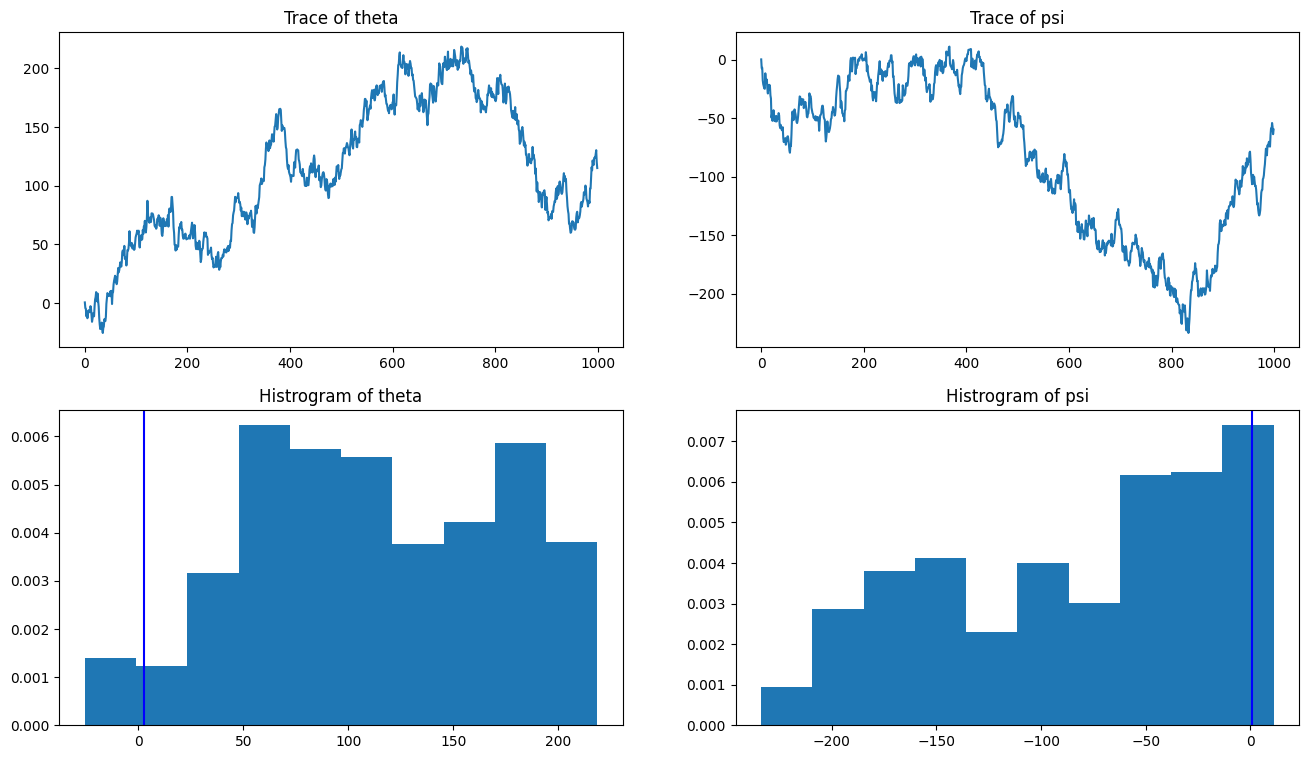

In [35]:
def posterior_plot(samples):
    thetas = samples[:,0]
    psis = samples[:,1]
    # Plotting
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 2, 1)
    plt.plot(thetas)
    plt.title(f"Trace of theta")

    plt.subplot(2, 2, 2)
    plt.plot(psis)
    plt.title(f"Trace of psi")

    plt.subplot(2, 2, 3)
    plt.title(f"Histrogram of theta")
    plt.hist(thetas, density=True)
    plt.axvline(x = true_theta, color = 'b', label = 'true theta')

    plt.subplot(2, 2, 4)
    plt.title(f"Histrogram of psi")
    plt.hist(psis, density=True)
    plt.axvline(x = true_psi, color = 'b', label = 'true psi')
    plt.show()


post_samples_MCMC = np.array(MCMC(num_iter = 1000, proposal_var = 5))
posterior_plot(post_samples_MCMC)


### e)
The likelihood should give more information if we have more samples. We therefore try to samples more observations with $n=100$ first:

/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:3: RuntimeWarning: invalid value encountered in log
  exponent = -(np.log(theta)**2 - 2 * rho * np.log(theta) * np.log(psi) + np.log(psi)**2) / (2 * (1 - rho**2))
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  A = min(1,joint(data,Y_curr)/joint(data,Y_propose))
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:35: RuntimeWarning: invalid value encountered in scalar divide
  A = min(1,joint(data,Y_curr)/joint(data,Y_propose))


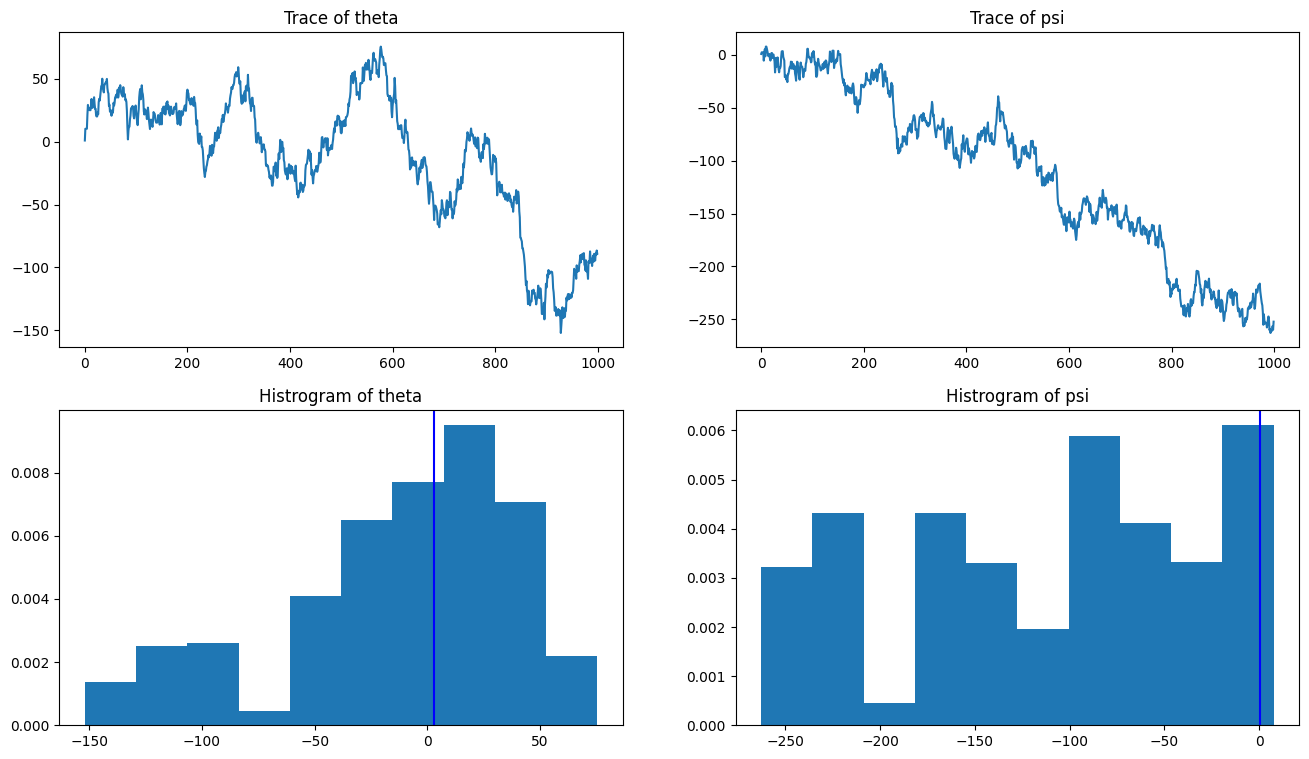

In [36]:
post_samples_100 = scipy.stats.norm.rvs(true_theta,np.sqrt(true_psi),size = 100)

post_samples_MCMC_100 = np.array(MCMC(num_iter = 1000, proposal_var = 5,data=post_samples_100))
posterior_plot(post_samples_MCMC_100)

/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:10: RuntimeWarning: overflow encountered in scalar power
  term1 = 1 / (np.sqrt(2*np.pi) *psi)**n
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:3: RuntimeWarning: invalid value encountered in log
  exponent = -(np.log(theta)**2 - 2 * rho * np.log(theta) * np.log(psi) + np.log(psi)**2) / (2 * (1 - rho**2))
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  term1 = 1 / (np.sqrt(2*np.pi) *psi)**n
/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_74911/3790406087.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return term1 * np.exp(exponent)


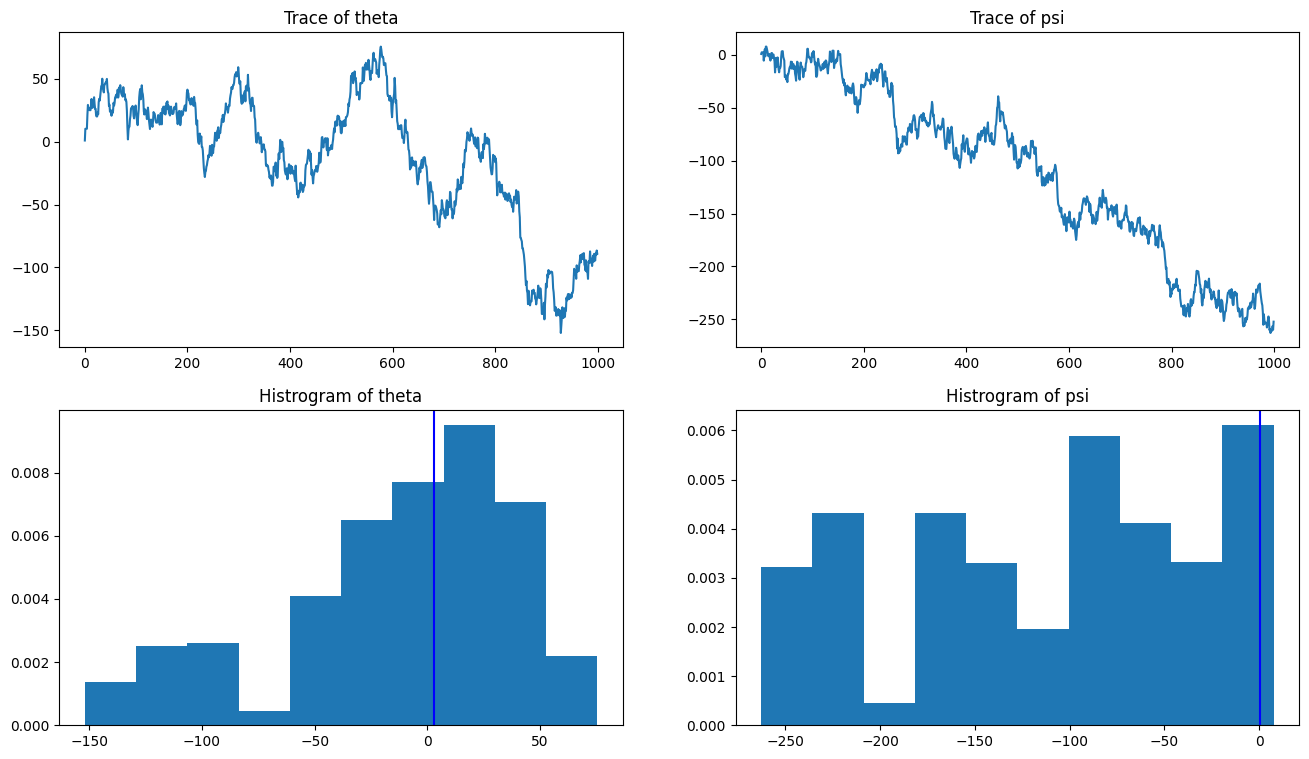

In [38]:
post_samples_1000 = scipy.stats.norm.rvs(true_theta,np.sqrt(true_psi),size = 1000)

post_samples_MCMC_1000 = np.array(MCMC(num_iter = 1000, proposal_var = 5,data=post_samples_1000))
posterior_plot(post_samples_MCMC_100)

We want to derive the posterior distribution of $(\theta,\psi)$ given a sample $X = [X_{1},..,X_{n}]$. 

We have   
$f_{X_{i}|\theta,\psi} (X_{i}|\theta,\psi) = \frac{1}{\psi \sqrt{2\pi}}e^{-0.5(\frac{X_{i}-\theta}{\psi})^2}$  
and    
$f(\theta,\psi) = \frac{1}{2\pi\theta\psi\sqrt{1-\rho^2}} e^{-\frac{log(\theta)^{2}-2\rho log(\theta)log(\psi)+log(\psi)^{2}}{2(1-\rho^2)}}$

We can then find    
$f_{X|\theta,\psi} (X_{i}|\theta,\psi)  = \prod_{i=1}^{n}f_{X_{i}|\theta,\psi} (X_{i}|\theta,\psi) =   \prod_{i=1}^{n} \frac{1}{\psi \sqrt{2\pi}}e^{-0.5(\frac{X_{i}-\theta}{\psi})^2} =  \frac{1}{(\psi \sqrt{2\pi})^n}e^{-\frac{1}{2\psi^2}\sum_{i=1}^{n} (X_{i}-\theta)^2}$  


We can now write the posterior distribution as   
$f_{\theta,\psi|X}(\theta,\psi) = \frac{f_{X|\theta,\psi}(X|\theta,\psi)\cdot f_{\theta,\psi}(\theta,\psi)}{f_{X}(X)} = c\cdot f_{X|\theta,\psi}(X|\theta,\psi)\cdot f_{\theta,\psi}(\theta,\psi)$